In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 
import torch 
import torch_geometric as pyg
import seaborn as sbn 
from scipy.stats import spearmanr, kendalltau 
from sklearn.metrics import r2_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import ConfusionMatrixDisplay

import sys 
sys.path.append('../')
from src.prioritize.utils import get_base_X, dose2scale
from src.uncertainty.utils import root_mean_squared_picp_error, compute_picp, compute_ECE

# Cell Viability Evaluation (2-agent combinations)

[Data Source](https://wiki.nci.nih.gov/display/NCIDTPdata/NCI-ALMANAC)   
[NCI Almanac Paper](https://pubmed.ncbi.nlm.nih.gov/28446463/)  
[NCI-60 protocol](https://dtp.cancer.gov/discovery_development/nci-60/methodology.htm)  

In [2]:
# load almanac data
almanac = pd.read_csv('../../data/ComboDrugGrowth_Nov2017/ComboDrugGrowth_Nov2017.csv')
almanac.head()

/tmp/ipykernel_5558/658519709.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  almanac = pd.read_csv('../../data/ComboDrugGrowth_Nov2017/ComboDrugGrowth_Nov2017.csv')


,COMBODRUGSEQ,SCREENER,STUDY,TESTDATE,PLATE,PANELNBR,CELLNBR,PREFIX1,NSC1,SAMPLE1,...,PERCENTGROWTH,PERCENTGROWTHNOTZ,TESTVALUE,CONTROLVALUE,TZVALUE,EXPECTEDGROWTH,SCORE,VALID,PANEL,CELLNAME
0,260496,FG,PZUT00156_86_01_T72,06/23/2011,786-0_1_T72,9,18,S,752,37,...,85.979,88.159,332168.0,376781.548,58592.854,90.342,4.0,Y,Renal Cancer,786-0
1,260497,FG,PZUT00156_86_01_T72,06/23/2011,786-0_1_T72,9,18,S,752,37,...,100.903,100.763,379656.0,376781.548,58592.854,87.130,-14.0,Y,Renal Cancer,786-0
2,260498,FG,PZUT00156_86_01_T72,06/23/2011,786-0_1_T72,9,18,S,752,37,...,14.147,27.498,103608.0,376781.548,58592.854,12.739,-1.0,Y,Renal Cancer,786-0
3,260499,FG,PZUT00156_86_01_T72,06/23/2011,786-0_1_T72,9,18,S,752,37,...,71.268,75.736,285360.0,376781.548,58592.854,76.397,5.0,Y,Renal Cancer,786-0
4,260500,FG,PZUT00156_86_01_T72,06/23/2011,786-0_1_T72,9,18,S,752,37,...,89.278,90.945,342664.0,376781.548,58592.854,73.681,-16.0,Y,Renal Cancer,786-0


In [3]:
# NSC ids -> drug names 
chemnames = pd.read_csv('../../data/ComboCompoundNames_all.txt', sep='\t',header=None).rename({0:'NSC', 1:'DrugName'}, axis=1)
chemnames = chemnames.assign(drugname=lambda x: x.DrugName.str.lower())
#chemnames = chemnames.assign(NSC=lambda x: x.NSC.values.astype(int))
chemnames.head(5)

,NSC,DrugName,drugname
0,740,Methotrexate,methotrexate
1,740,Trexall,trexall
2,740,Abitrexate,abitrexate
3,740,Mexate,mexate
4,740,Folex,folex


In [4]:
# exp meta data 
data = torch.load('../output/SignalTransduction/proc/Data.pt')
#data = torch.load('../output/exp1/proc/Data.pt')
druginfo = pd.read_csv('../../data/compoundinfo_beta.txt', sep='\t')[lambda x: x.pert_id.isin(data.drugspace)]
druginfo = druginfo.assign(cmap_name_lower = lambda x: x.cmap_name.str.lower())
druginfo = druginfo.assign(compound_aliases_lower = lambda x: x.compound_aliases.str.lower())
druginfo.head()

,pert_id,cmap_name,target,moa,canonical_smiles,inchi_key,compound_aliases,cmap_name_lower,compound_aliases_lower
410,BRD-K42805893,AZD-9291,NaN,NaN,COc1cc(N(C)CCN(C)C)c(NC(=O)C=C)cc1Nc1nccc(n1)-...,DUYJMQONPNNFPI-UHFFFAOYSA-N,osimertinib,azd-9291,osimertinib
508,BRD-K62391742,GDC-0199,NaN,NaN,CC1(C)CCC(CN2CCN(CC2)c2ccc(C(=O)NS(=O)(=O)c3cc...,LQBVNQSMGBZMKD-UHFFFAOYSA-N,venetoclax,gdc-0199,venetoclax
605,BRD-K43002773,GDC-0068,AKT3,Akt inhibitor,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...,GRZXWCHAXNAUHY-NSISKUIASA-N,ipatasertib,gdc-0068,ipatasertib
606,BRD-K43002773,GDC-0068,AKT1,Akt inhibitor,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...,GRZXWCHAXNAUHY-NSISKUIASA-N,ipatasertib,gdc-0068,ipatasertib
607,BRD-K43002773,GDC-0068,AKT2,Akt inhibitor,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...,GRZXWCHAXNAUHY-NSISKUIASA-N,ipatasertib,gdc-0068,ipatasertib


In [5]:
almanac_NSCs = np.unique(almanac.NSC1.values.astype(int).tolist() + almanac.NSC2.values.astype(int).tolist())
chemnames2 = chemnames[lambda x: x.NSC.isin(almanac_NSCs.astype(str))]
#','.join(chemnames2.DrugName.unique())
#chemnames2.DrugName.unique()[1250:]
#len(chemnames2.DrugName.unique())

In [6]:
# NOTE: these were generated using chat-GPT to match NCI chemical names to brad `cmap_name`s; all of them are pretty straight forward - 

nci2brd_gpt = {
    "Tamoxifen": "tamoxifen",
    "Pentostatin": "pentostatin",
    "Sirolimus": "sirolimus",
    "Carboplatin": "carboplatin",
    "Valrubicin": "valrubicin",
    "Idarubicin hydrochloride": "idarubicin",
    "Epirubicin": "epirubicin",
    "Oxaliplatin": "oxaliplatin",
    "Mitoxantrone": "mitoxantrone",
    "Amifostine": "amifostine",
    "Temozolomide": "temozolomide",
    "Imiquimod": "imiquimod",
    "Carmustine": "carmustine",
    "Clofarabine": "clofarabine",
    "Vinorelbine tartrate": "vinorelbine",
    "Topotecan hydrochloride": "topotecan",
    "Gemcitabine hydrochloride": "gemcitabine",
    "Docetaxel": "docetaxel",
    "Bortezomib": "bortezomib",
    "Nelarabine": "nelarabine",
    "Pemetrexed Disodium": "pemetrexed",
    "Vorinostat": "vorinostat",
    "Estramustine phosphate sodium": "estramustine",
    "Capecitabine": "capecitabine",
    "Exemestane": "exemestane",
    "Gefitinib": "gefitinib",
    "Erlotinib hydrochloride": "erlotinib",
    "Fulvestrant": "fulvestrant",
    "Anastrozole": "anastrozole",
    "Letrozole": "letrozole",
    "Celecoxib": "celecoxib",
    "Zoledronic acid": "zoledronic acid",
    "Dasatinib": "dasatinib",
    "Everolimus": "everolimus",
    "Imatinib mesylate": "imatinib",
    "Lapatinib ditosylate": "lapatinib",
    "Nilotinib": "nilotinib",
    "Sorafenib tosylate": "sorafenib",
    "Lenalidomide": "lenalidomide",
    "Ixabepilone": "ixabepilone",
    "Raloxifene hydrochloride": "raloxifene",
    "Abiraterone": "abiraterone",
    "Sunitinib (free base)": "sunitinib",
    "Depsipeptide": "romidepsin",               # checked : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6659113/
    "Pralatrexate": "pralatrexate",
    "Vismodegib": "vismodegib",
    "Crizotinib": "crizotinib",
    "Axitinib": "axitinib",
    "Vandetanib": "vandetanib",
    "Vemurafenib": "vemurafenib",
    "Cabazitaxel": "cabazitaxel"
}

_nci2brd_gpt= {}
wrong = 0
for key, value in nci2brd_gpt.items(): 
    if (key in chemnames2.DrugName.unique()) and (value in druginfo.cmap_name.unique()): 
        _nci2brd_gpt[key] = value 
    else:
        wrong +=1 

print('# wrong matches', wrong)
print('# of potential matches:', len(_nci2brd_gpt))

nci2brd_gpt = pd.DataFrame(_nci2brd_gpt, index=[0]).T.reset_index().rename({'index':'DrugName', 0:'cmap_name'}, axis=1).merge(chemnames2[['NSC', 'DrugName']].drop_duplicates(), on='DrugName').merge(druginfo[['pert_id', 'cmap_name']], on='cmap_name')
nci2brd_gpt.head()

# wrong matches 28
# of potential matches: 23


,DrugName,cmap_name,NSC,pert_id
0,Tamoxifen,tamoxifen,180973,BRD-K04210847
1,Tamoxifen,tamoxifen,180973,BRD-K04210847
2,Tamoxifen,tamoxifen,180973,BRD-K93754473
3,Tamoxifen,tamoxifen,180973,BRD-K93754473
4,Tamoxifen,tamoxifen,180973,BRD-K43744935


In [7]:
# match NSC ids -> pert_id
nci2brd1 = druginfo[['pert_id', 'cmap_name_lower']].drop_duplicates().dropna().merge(chemnames2[['NSC', 'drugname']].drop_duplicates().dropna(), left_on='cmap_name_lower', right_on='drugname')
nci2brd2 = druginfo[['pert_id', 'compound_aliases_lower']].drop_duplicates().dropna().merge(chemnames2[['NSC', 'drugname']].drop_duplicates().dropna(), left_on='compound_aliases_lower', right_on='drugname')
print(len(nci2brd1))
print(len(nci2brd2))

nci2brd = pd.concat([nci2brd_gpt[['NSC', 'pert_id']], nci2brd1[['NSC', 'pert_id']], nci2brd2[['NSC', 'pert_id']]], axis=0, ignore_index=False).drop_duplicates()
print(len(nci2brd))
nci2brd.head()

48
0
50


,NSC,pert_id
0,180973,BRD-K04210847
2,180973,BRD-K93754473
4,180973,BRD-K43744935
12,226080,BRD-K99369265
14,226080,BRD-K84937637


In [8]:
# drugs in alamanac and the GSNN data space 
# including gpt matchings only adds +1 drug 
NSCspace = nci2brd.NSC.unique().astype(int)
print('# almanac drugs in `data`', len(NSCspace))
NSCspace

# almanac drugs in `data` 32


array([180973, 226080, 362856, 628503, 681239, 701852, 715055, 718781,
       719276, 732517, 733504, 743414, 745750, 747599, 747971, 747972,
       747974, 750690, 754143, 755986, 756645, 757441, 760766, 761431,
        14229, 125973, 119875, 141540, 122758,  66847,    740,  32065])

In [9]:
# filter to NSCspace 
almanac2 = almanac[lambda x: x.NSC1.isin(NSCspace) & x.NSC2.isin(NSCspace)]
print(almanac2.shape[0])

253719


In [10]:
almanac2.CELLNAME.unique()

array(['786-0', 'A498', 'A549/ATCC', 'ACHN', 'CCRF-CEM', 'COLO 205',
       'DU-145', 'EKVX', 'HCC-2998', 'HCT-15', 'HCT-116', 'HL-60(TB)',
       'HOP-62', 'HOP-92', 'HT29', 'IGROV1', 'K-562', 'KM12', 'LOX IMVI',
       'MALME-3M', 'MCF7', 'MOLT-4', 'NCI/ADR-RES', 'NCI-H23', 'NCI-H226',
       'NCI-H322M', 'NCI-H460', 'OVCAR-4', 'OVCAR-8', 'RPMI-8226',
       'SF-268', 'SF-295', 'SF-539', 'SK-OV-3', 'SNB-19', 'SNB-75', 'SR',
       'SW-620', 'U251', 'UACC-257', 'MDA-MB-468', 'T-47D', 'TK-10',
       'BT-549', 'M14', 'MDA-MB-435', 'NCI-H522', 'UACC-62', 'SK-MEL-5',
       'OVCAR-5', 'PC-3', 'RXF 393', 'SK-MEL-2', 'SN12C', 'UO-31',
       'CAKI-1', 'HS 578T', 'MDA-MB-231/ATCC', 'OVCAR-3', 'SK-MEL-28'],
      dtype=object)

In [11]:
data.cellspace

array(['22RV1', '5637', 'A204', 'A375', 'A549', 'AGS', 'BC3C', 'BEN',
       'BICR6', 'BT20', 'BT474', 'CAL29', 'CJM', 'COV434', 'CW2', 'DV90',
       'ES2', 'G401', 'GI1', 'GP2D', 'HCC95', 'HCT116', 'HEC108',
       'HEC151', 'HEC1A', 'HEC251', 'HEC265', 'HEPG2', 'HL60', 'HS578T',
       'HUH7', 'IGR37', 'J82', 'JURKAT', 'K562', 'KMS34', 'LN229', 'MCF7',
       'MDAMB231', 'MDAMB468', 'MELHO', 'MINO', 'MKN45', 'NALM6',
       'NCIH1437', 'NCIH1781', 'NCIH1975', 'NCIH2110', 'NCIH2172',
       'NCIH508', 'NCIH596', 'NCIH838', 'NCIH841', 'OAW28', 'OCILY19',
       'OCILY3', 'OVCAR8', 'OVK18', 'OVTOKO', 'PC3', 'RCC10RGB', 'SH4',
       'SKBR3', 'SKES1', 'SKMEL3', 'SKMEL5', 'SKNSH', 'SNU1040', 'SNU407',
       'T47D', 'THP1', 'TOV112D', 'U251MG', 'U2OS', 'U937', 'VCAP',
       'VMCUB1', 'YAPC', 'YH13', 'ZR751'], dtype='<U8')

In [12]:
nci2iname = {
    'MCF7': 'MCF7',
    'MDA-MB-231/ATCC': 'MDAMB231',
    'A549/ATCC': 'A549',
    'HCT-116': 'HCT116',
    'HS 578T': 'HS578T',
    'K-562': 'K562',
    'MDA-MB-468': 'MDAMB468',
    'OVCAR-8': 'OVCAR8',
    'PC-3': 'PC3',
    'SK-MEL-5': 'SKMEL5',
    'T-47D': 'T47D',
    'HL-60(TB)': 'HL60',  
    'U251': 'U251MG' 
}

for x in list(nci2iname.keys()): 
    assert x in almanac2.CELLNAME.unique(), f'{x} not in almanac cell names'

for x in list(nci2iname.values()):
    assert x in data.cellspace, f'{x} not in data cellspace'

len(nci2iname)

13

In [13]:
# filter to cellspace 
almanac3 = almanac2[lambda x: x.CELLNAME.isin(nci2iname.keys())]
almanac3.shape[0]

55350

In [14]:
nci2brd_dict = nci2brd.set_index('NSC').to_dict()['pert_id']

In [15]:
# convert NSC1/2 to broad ID 
almanac3 = almanac3.assign(pert_id_1 = lambda x: [nci2brd_dict[str(int(xx))] for xx in x.NSC1])
almanac3 = almanac3.assign(pert_id_2 = lambda x: [nci2brd_dict[str(int(xx))] for xx in x.NSC2])

# convert CELLNAME in cell_iname 
almanac3 = almanac3.assign(cell_iname = lambda x: [nci2iname[str(xx)] for xx in x.CELLNAME])

# select relevenat columsn 
almanac4 = almanac3[['pert_id_1', 'pert_id_2', 'CONC1', 'CONC2', 'CONCUNIT1', 'CONCUNIT2', 'PERCENTGROWTH', 'PERCENTGROWTHNOTZ', 'cell_iname', 'VALID', 'TESTVALUE', 'CONTROLVALUE', 'TZVALUE']].reset_index(drop=True)
almanac4 = almanac4[lambda x: x.VALID == 'Y']

print(almanac4.shape)
almanac4.head()

(55350, 13)


,pert_id_1,pert_id_2,CONC1,CONC2,CONCUNIT1,CONCUNIT2,PERCENTGROWTH,PERCENTGROWTHNOTZ,cell_iname,VALID,TESTVALUE,CONTROLVALUE,TZVALUE
0,BRD-K37798499,BRD-K64052750,5.000000e-08,1.000000e-07,M,M,91.458,92.231,A549,Y,460368.0,499148.0,45173.042
1,BRD-K37798499,BRD-K64052750,5.000000e-08,1.000000e-06,M,M,73.929,76.288,A549,Y,380792.0,499148.0,45173.042
2,BRD-K37798499,BRD-K64052750,5.000000e-08,1.000000e-05,M,M,58.510,62.264,A549,Y,310792.0,499148.0,45173.042
3,BRD-K37798499,BRD-K64052750,5.000000e-07,1.000000e-07,M,M,46.347,51.202,A549,Y,255576.0,499148.0,45173.042
4,BRD-K37798499,BRD-K64052750,5.000000e-07,1.000000e-06,M,M,38.686,44.235,A549,Y,220800.0,499148.0,45173.042


In [16]:
almanac4[['pert_id_1', 'pert_id_2']].drop_duplicates().shape

(484, 2)

In [17]:
#[(Ti-Tz)/(C-Tz)] x 100 for concentrations for which Ti>/=Tz
#[(Ti-Tz)/Tz] x 100 for concentrations for which Ti<Tz.
#cvtz = (almanac4.TESTVALUE - almanac4.TZVALUE) / (almanac4.CONTROLVALUE - almanac4.TZVALUE) # PERCENTGROWTHNOTZ ~ computed as test optical density divided by control optical value 
#plt.plot(cvtz, almanac4.PERCENTGROWTH, 'k.')

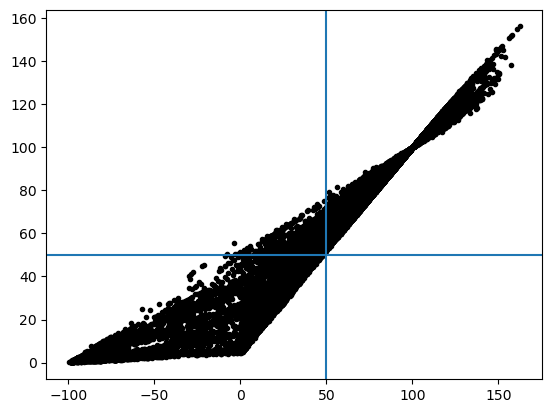

In [18]:
plt.plot(almanac4.PERCENTGROWTH, almanac4.PERCENTGROWTHNOTZ, 'k.')
plt.axvline(50)
plt.axhline(50)

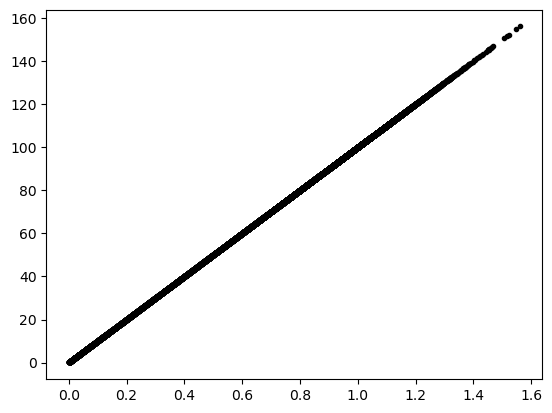

In [19]:
cv = almanac4.TESTVALUE / almanac4.CONTROLVALUE # PERCENTGROWTHNOTZ ~ computed as test optical density divided by control optical value 
plt.plot(cv, almanac4.PERCENTGROWTHNOTZ, 'k.')

In [20]:
siginfo = pd.read_csv(f'../../data/siginfo_beta.txt', sep='\t', low_memory=False)
cell_x_dict = {cell:get_base_X([cell], '../output/SignalTransduction/proc/', data, siginfo) for cell in data.cellspace}
#cell_x_dict = {cell:get_base_X([cell], '../output/exp1/proc/', data, siginfo) for cell in data.cellspace}

In [21]:
# create x values (cell input + drug idx + conc )

X = [] 
y = []
for i,row in almanac4.iterrows(): 
    print(f'progress: {i}/{almanac4.shape[0]}', end='\r')

    # get no-drug cell features 
    xx = cell_x_dict[row.cell_iname].clone().detach()

    # get drug idx 
    drug_idx1 = data.node_names.tolist().index('DRUG__' + row.pert_id_1)
    drug_idx2 = data.node_names.tolist().index('DRUG__' + row.pert_id_2)

    conc_um1 = row.CONC1 * 1e6
    conc_um2 = row.CONC2 * 1e6

    xx[:, drug_idx1] = dose2scale(conc_um1)
    xx[:, drug_idx2] = dose2scale(conc_um2)

    X.append(xx.detach())

    #yy = torch.clip(torch.tensor([row.PERCENTGROWTH / 100]), 0,1)
    #yy = torch.log(torch.tensor([row.TESTVALUE / row.TZVALUE]))
    yy = torch.tensor([row.PERCENTGROWTHNOTZ / 100])
    y.append(yy.detach())
    
print()
print()

X = torch.cat(X, dim=0)
y = torch.stack(y)

print(X.size())
print(y.size())


progress: 55349/55350

torch.Size([55350, 13314])
torch.Size([55350, 1])


In [22]:
#expr_gsnn = torch.load('../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/model-100.pt')
#viab_gsnn = torch.load('../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/ViabNNEnsemble.pt')

expr_gsnn = torch.load('../output/SignalTransduction/FOLD-1/GSNN/c82456f4-6c84-4100-a83a-5d6d6d80b94d/model-100.pt')
viab_gsnn = torch.load('../output/SignalTransduction/FOLD-1/GSNN/c82456f4-6c84-4100-a83a-5d6d6d80b94d/ViabNNEnsemble.pt')


expr_nn = torch.load('../output/exp1/FOLD-1/NN/872dcbb7-e641-47af-ba26-8ea820c583d6/model-100.pt')
viab_nn = torch.load('../output/exp1/FOLD-1/NN/872dcbb7-e641-47af-ba26-8ea820c583d6/ViabNNEnsemble.pt')

In [23]:
expr_gsnn.eval()
gsnn_expr_hat = []
for batch_idxs in torch.split(torch.arange(X.size(0)), 1024): 
    print(f'progress: {batch_idxs[-1]}/{len(X)}', end='\r')
    with torch.no_grad(): 
        gsnn_expr_hat.append(expr_gsnn(X[batch_idxs].unsqueeze(-1).cuda())[:, data.output_node_mask].detach().cpu())

gsnn_expr_hat = torch.cat(gsnn_expr_hat, axis=0).squeeze(-1)

In [35]:
expr_gsnn.eval()
nn_expr_hat = []
for batch_idxs in torch.split(torch.arange(X.size(0)), 1024): 
    print(f'progress: {batch_idxs[-1]}/{len(X)}', end='\r')
    with torch.no_grad(): 
        nn_expr_hat.append(expr_nn(X[batch_idxs][:, data.input_node_mask].cuda()).detach().cpu())

nn_expr_hat = torch.cat(nn_expr_hat, axis=0).squeeze(-1)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x9162 and 3510x1000)

In [24]:
def combo_eval(yhat_means, yhat_vars, y, meta):

    meta = meta.reset_index()

    comb_perf = {'pert_id_1':[], 'pert_id_2':[], 'r':[], 'r2':[], 'mse':[], 'N':[], 'mean_var':[]}
    for i,row in meta[['pert_id_1', 'pert_id_2']].drop_duplicates().iterrows():

        comb_idxs1 = meta[lambda x: (x.pert_id_1 == row.pert_id_1) & (x.pert_id_2 == row.pert_id_2)].index 
        comb_idxs2 = meta[lambda x: (x.pert_id_2 == row.pert_id_1) & (x.pert_id_1 == row.pert_id_2)].index 
        comb_idxs = list(comb_idxs1) + list(comb_idxs2)
        r = np.corrcoef(yhat_means[comb_idxs].detach().cpu().numpy().ravel(), y[comb_idxs].detach().cpu().numpy().ravel())[0,1]
        r2 = r2_score(y[comb_idxs].detach().cpu().numpy().ravel(), yhat_means[comb_idxs].detach().cpu().numpy().ravel())
        mean_var = yhat_vars[comb_idxs].mean().detach().cpu().item()
        mse = np.mean((yhat_means[comb_idxs].detach().cpu().numpy().ravel() - y[comb_idxs].detach().cpu().numpy().ravel())**2)

        comb_perf['pert_id_1'].append(row.pert_id_1)
        comb_perf['pert_id_2'].append(row.pert_id_2)
        comb_perf['r'].append(r)
        comb_perf['mse'].append(mse)
        comb_perf['r2'].append(r2)
        comb_perf['N'].append(len(comb_idxs))
        comb_perf['mean_var'].append(mean_var)

    comb_perf = pd.DataFrame(comb_perf)
    return comb_perf

In [25]:
def batch_predict(model, X, batch=1024, verbose=True): 

    means = [] 
    vars = [] 
    for idxs in torch.split(torch.arange(X.shape[0]), batch): 
        if verbose: print(f'progress: {idxs[-1]}/{len(X)}', end='\r')
        dist = model(X[idxs,:])
        means.append(dist.mean.detach().cpu())
        vars.append(dist.variance.detach().cpu())

    return torch.cat(means, dim=0), torch.cat(vars, dim=0)

In [26]:
yhat_means_gsnn, yhat_vars_gsnn = batch_predict(model=viab_gsnn, X=gsnn_expr_hat, batch=1024, verbose=True)

r_gsnn = np.corrcoef(y.squeeze(-1).detach().cpu().numpy(), yhat_means_gsnn.detach().cpu().numpy().ravel())[0,1]
print('r (gsnn):', r_gsnn)

r2_gsnn = r2_score(y.squeeze(-1).detach().cpu().numpy().ravel(), yhat_means_gsnn.detach().cpu().numpy().ravel())
print('r2 (gsnn):', r2_gsnn)

mse_gsnn = torch.mean((y.view(-1) - yhat_means_gsnn.view(-1))**2).item()
print('mse (gsnn):', mse_gsnn)

r (gsnn): 0.25762824916401006
r2 (gsnn): -0.26629306228107463
mse (gsnn): 0.10403994470834732


In [36]:
r_gsnn = np.corrcoef(y.squeeze(-1).detach().cpu().numpy(), yhat_means_gsnn.detach().cpu().numpy().ravel())[0,1]
print('r (gsnn):', r_gsnn)

r2_gsnn = r2_score(y.squeeze(-1).detach().cpu().numpy(), yhat_means_gsnn.detach().cpu().numpy().ravel())
print('r2 (gsnn):', r2_gsnn)

#r_gsnn = spearmanr(y.squeeze(-1).detach().cpu().numpy(), yhat_means_gsnn.detach().cpu().numpy()).statistic
mse_gsnn = torch.mean((y - yhat_means_gsnn)**2).item()
print('mse (gsnn):', mse_gsnn)
#ece_gsnn = compute_ECE(yhat_dist_gsnn, y)

print('r (gsnn):', r_gsnn)
print('r2 (gsnn):', r2_gsnn)
print('mse (gsnn):', mse_gsnn)
#print('ece (gsnn):', ece_gsnn)

KeyboardInterrupt: 

In [48]:
yhat_dist_nn = viab_nn(nn_expr_hat)
yhat_means_nn = yhat_dist_nn.mean
yhat_vars_nn = yhat_dist_nn.variance

r_nn = np.corrcoef(y.squeeze(-1).detach().cpu().numpy().ravel(), yhat_means_nn.detach().cpu().numpy().ravel())[0,1]
r2_nn = r2_score(y.squeeze(-1).detach().cpu().numpy().ravel(), yhat_means_nn.detach().cpu().numpy().ravel())
#r_nn = spearmanr(y.squeeze(-1).detach().cpu().numpy(), yhat_means_nn.detach().cpu().numpy()).statistic
mse_nn = torch.mean((y.view(-1) - yhat_means_nn.view(-1))**2).item()
ece_nn = compute_ECE(yhat_dist_nn, y)

print('r (nn):', r_nn)
print('r2 (nn):', r2_nn)
print('mse (nn):', mse_nn)
print('ece (nn):', ece_nn)

r (nn): 0.21738177908764503
r2 (nn): -2.5002748321824773
mse (nn): 0.34158188104629517
ece (nn): 0.35592191480100155


In [49]:
yhat_means_rand = torch.rand_like(yhat_dist_nn.mean)

r_rand = np.corrcoef(y.squeeze(-1).detach().cpu().numpy(), yhat_means_rand.detach().cpu().numpy().ravel())[0,1]
r2_rand = r2_score(y.squeeze(-1).detach().cpu().numpy(), yhat_means_rand.detach().cpu().numpy().ravel())
#r_nn = spearmanr(y.squeeze(-1).detach().cpu().numpy(), yhat_means_nn.detach().cpu().numpy()).statistic
mse_rand = torch.mean((y - yhat_means_rand)**2).item()

print('r (rand):', r_rand)
print('r2 (rand):', r2_rand)
print('mse (rand):', mse_rand)

r (rand): -0.005066411959988238
r2 (rand): -2.1311865182407725
mse (rand): 0.2717065215110779


In [27]:
gsnn_res = combo_eval(yhat_means_gsnn, yhat_vars_gsnn, y, meta=almanac4)
gsnn_res.head()

,pert_id_1,pert_id_2,r,r2,mse,N,mean_var
0,BRD-K37798499,BRD-K64052750,0.252189,-0.868409,0.138887,117,0.030886
1,BRD-K37798499,BRD-A17883755,0.073669,-0.506935,0.124610,117,0.050914
2,BRD-K64052750,BRD-A17883755,0.709051,0.257651,0.021466,117,0.031706
3,BRD-M64432851,BRD-K64634304,-0.060949,-4.013274,0.053819,117,0.058957
4,BRD-M64432851,BRD-K62008436,0.426204,0.111624,0.083351,117,0.064876


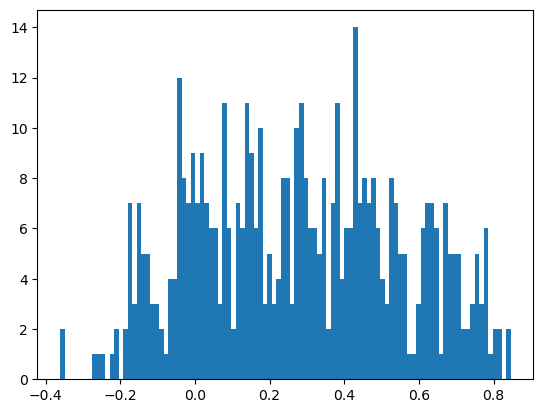

In [30]:
plt.figure()
plt.hist(gsnn_res.r, bins=100)
plt.show()

In [84]:
gsnn_res = combo_eval(yhat_means_gsnn, yhat_vars_gsnn, y, meta=almanac4)
nn_res = combo_eval(yhat_means_nn, yhat_vars_nn, y, meta=almanac4)
_res = gsnn_res.rename({'r':'r_gsnn'}, axis=1).merge(nn_res.rename({'r':'r_nn'}, axis=1), on=['pert_id_1', 'pert_id_2'])
_res.head()

,pert_id_1,pert_id_2,r_gsnn,r2_x,mse_x,N_x,mean_var_x,r_nn,r2_y,mse_y,N_y,mean_var_y
0,BRD-M64432851,BRD-K62008436,0.389591,-0.122423,0.105311,117,0.051517,0.512571,-1.726250,0.255789,117,0.044323
1,BRD-M64432851,BRD-K43744935,-0.062963,-4.861769,0.052119,117,0.042975,0.123667,-50.979004,0.462166,117,0.051711
2,BRD-M64432851,BRD-A79768653,-0.140581,-1.958491,0.036599,117,0.029487,0.227640,-15.680705,0.206352,117,0.050781
3,BRD-M64432851,BRD-K30577245,0.312106,-0.199660,0.064595,117,0.047463,0.410953,-3.974022,0.267822,117,0.037672
4,BRD-M64432851,BRD-K81418486,0.656441,0.406964,0.026751,117,0.023555,0.470778,-4.569467,0.251231,117,0.049697


In [85]:
# romidepsin (BRD-K61397605) is poorly predicted by GSNN 
#_res[lambda x: x.mean_var_x > 0.1].merge(druginfo[['pert_id', 'cmap_name']].drop_duplicates(), left_on='pert_id_1', right_on='pert_id', how='left').merge(druginfo[['pert_id', 'cmap_name']].drop_duplicates(), left_on='pert_id_2', right_on='pert_id', how='left')
_res2 = _res.merge(druginfo[['pert_id', 'cmap_name']].drop_duplicates(), left_on='pert_id_1', right_on='pert_id', how='left').merge(druginfo[['pert_id', 'cmap_name']].drop_duplicates(), left_on='pert_id_2', right_on='pert_id', how='left').assign(r_diff = lambda x: x.r_gsnn - r_nn)
_res2.sort_values('r_diff')
#_res2.groupby(['cmap_name_x',])[['r_diff']].mean().sort_values(by='r_diff')

,pert_id_1,pert_id_2,r_gsnn,r2_x,mse_x,N_x,mean_var_x,r_nn,r2_y,mse_y,N_y,mean_var_y,pert_id_x,cmap_name_x,pert_id_y,cmap_name_y,r_diff
127,BRD-K70401845,BRD-K19687926,-0.356934,-31.204414,0.239887,117,0.035057,-0.072296,-92.593324,0.697165,117,0.019078,BRD-K70401845,erlotinib,BRD-K19687926,lapatinib,-0.574316
223,BRD-K19687926,BRD-K77625799,-0.213230,-4.551885,0.191594,117,0.037125,-0.010855,-17.500601,0.638449,117,0.027019,BRD-K19687926,lapatinib,BRD-K77625799,vandetanib,-0.430612
115,BRD-K61397605,BRD-K64052750,-0.168118,-0.582679,0.223760,117,0.112442,0.737084,0.529432,0.066529,117,0.040623,BRD-K61397605,romidepsin,BRD-K64052750,gefitinib,-0.385500
16,BRD-K19687926,BRD-K49328571,-0.145528,-3.317492,0.238225,117,0.037920,0.107068,-6.976551,0.440119,117,0.043193,BRD-K19687926,lapatinib,BRD-K49328571,dasatinib,-0.362910
168,BRD-A45889380,BRD-K49810818,-0.145320,-0.590827,0.077228,108,0.032311,0.120306,-12.179803,0.639827,108,0.018485,BRD-A45889380,mepacrine,BRD-K49810818,sorafenib,-0.362702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,BRD-K92723993,BRD-K78431006,0.765064,0.468567,0.037717,117,0.029873,0.331283,-6.391083,0.524558,117,0.025809,BRD-K92723993,imatinib,BRD-K78431006,crizotinib,0.547682
171,BRD-K88510285,BRD-K70401845,0.767103,0.561688,0.078780,117,0.046148,0.576630,0.330323,0.120364,117,0.062409,BRD-K88510285,bortezomib,BRD-K70401845,erlotinib,0.549721
253,BRD-K64052750,BRD-K63828191,0.775560,0.598431,0.021176,117,0.029735,0.403828,-3.861846,0.256376,117,0.048673,BRD-K64052750,gefitinib,BRD-K63828191,raloxifene,0.558178
224,BRD-K81528515,BRD-K63828191,0.789989,0.408245,0.030149,117,0.027073,0.366649,-4.589751,0.284785,117,0.063030,BRD-K81528515,nilotinib,BRD-K63828191,raloxifene,0.572608


In [86]:
_res[['r_gsnn', 'r_nn']].corr()

,r_gsnn,r_nn
r_gsnn,1.000000,0.193562
r_nn,0.193562,1.000000


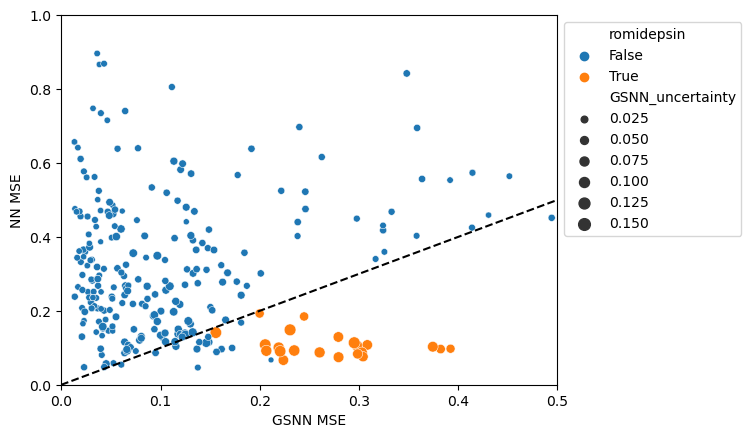

In [95]:
f, ax = plt.subplots()
#sbn.scatterplot(x='r_gsnn', y='r_nn', data=_res.assign(vandetanib_comb = lambda x: (x.pert_id_1 == 'BRD-K77625799') | (x.pert_id_2 == 'BRD-K77625799')), hue='vandetanib_comb')
sbn.scatterplot(x='mse_x', y='mse_y', data=_res.assign(romidepsin = lambda x: (x.pert_id_1 == 'BRD-K61397605') | (x.pert_id_2 == 'BRD-K61397605'), GSNN_uncertainty=lambda x: x.mean_var_x), hue='romidepsin', size='GSNN_uncertainty')
#plt.plot(_res.r_gsnn.mean(), _res.r_nn.mean(), 'ro')
plt.plot((-0.5, 1.), (-0.5, 1.), 'k--')
plt.xlabel('GSNN MSE')
plt.ylabel('NN MSE')
#plt.title('2-drug combination viability prediction')
plt.xlim(0,0.5)
plt.ylim(0,1)
sbn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

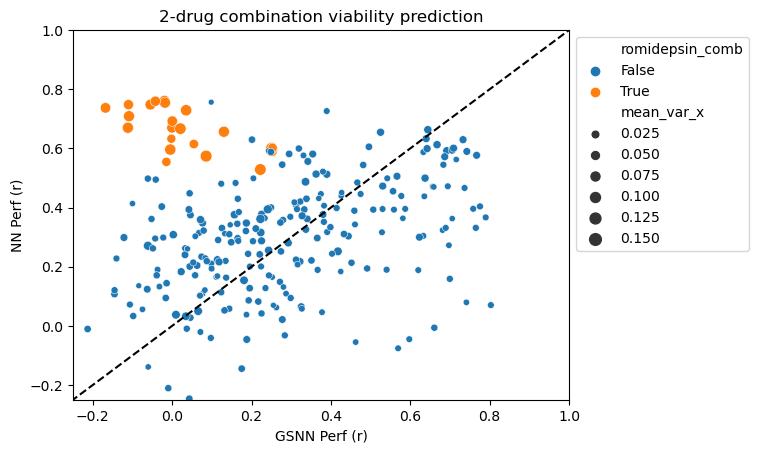

In [87]:
f, ax = plt.subplots()
#sbn.scatterplot(x='r_gsnn', y='r_nn', data=_res.assign(vandetanib_comb = lambda x: (x.pert_id_1 == 'BRD-K77625799') | (x.pert_id_2 == 'BRD-K77625799')), hue='vandetanib_comb')
sbn.scatterplot(x='r_gsnn', y='r_nn', data=_res.assign(romidepsin_comb = lambda x: (x.pert_id_1 == 'BRD-K61397605') | (x.pert_id_2 == 'BRD-K61397605')), hue='romidepsin_comb', size='mean_var_x')
#plt.plot(_res.r_gsnn.mean(), _res.r_nn.mean(), 'ro')
plt.plot((-0.5, 1.), (-0.5, 1.), 'k--')
plt.xlabel('GSNN Perf (r)')
plt.ylabel('NN Perf (r)')
plt.title('2-drug combination viability prediction')
plt.xlim(-0.25,1)
plt.ylim(-0.25,1)
sbn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

<Axes: xlabel='r_gsnn', ylabel='mean_var_x'>

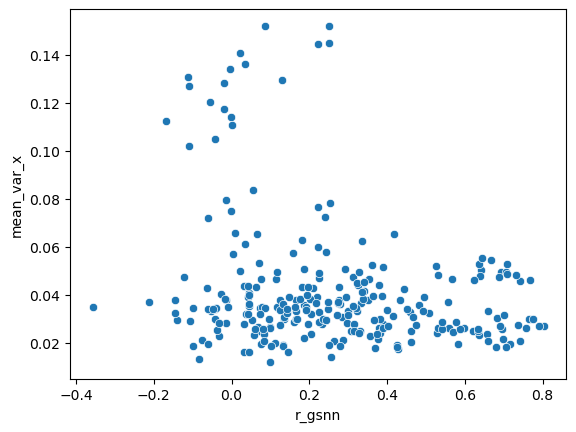

In [168]:
sbn.scatterplot(x='r_gsnn', y='mean_var_x', data=_res)

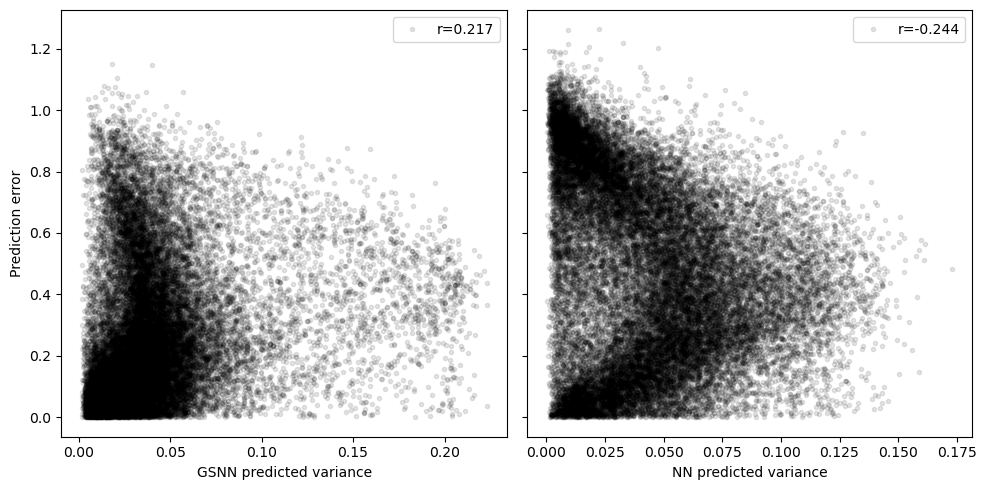

In [169]:
err_gsnn = torch.abs(yhat_means_gsnn - y.squeeze(-1))
err_nn = torch.abs(yhat_means_nn - y.squeeze(-1))

f,axes = plt.subplots(1,2, figsize=(10,5), sharey=True)
axes[0].plot(yhat_vars_gsnn.detach().cpu().numpy(), err_gsnn.detach().cpu().numpy(), 'k.', alpha=0.1, label=f'r={np.corrcoef(yhat_vars_gsnn.detach().cpu().numpy(), err_gsnn.detach().cpu().numpy())[0,1]:.3f}')
axes[1].plot(yhat_vars_nn.detach().cpu().numpy(), err_nn.detach().cpu().numpy(), 'k.', alpha=0.1 , label=f'r={np.corrcoef(yhat_vars_nn.detach().cpu().numpy(), err_nn.detach().cpu().numpy())[0,1]:.3f}')
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel('GSNN predicted variance')
axes[0].set_ylabel('Prediction error')
axes[1].set_xlabel('NN predicted variance')
plt.tight_layout()
plt.show()

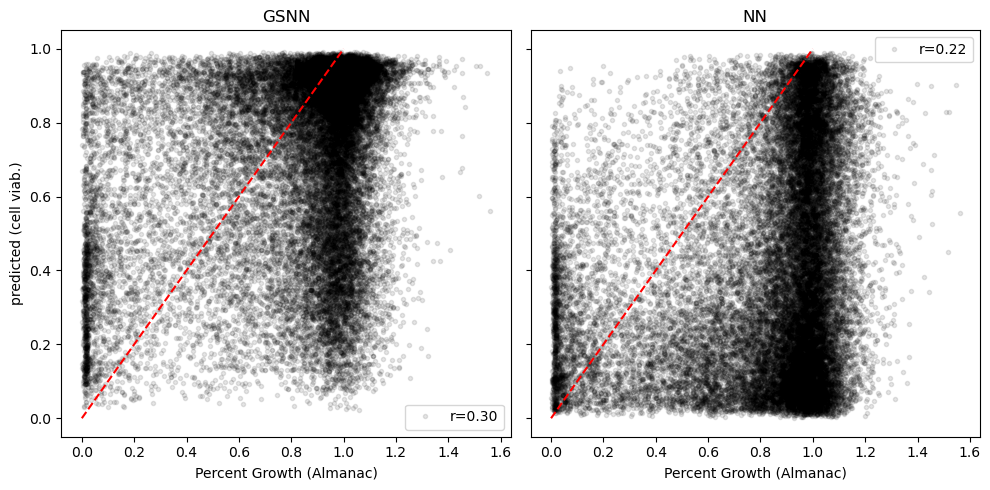

In [170]:
f,axes = plt.subplots(1,2, figsize=(10,5), sharey=True)
axes[0].plot(y.squeeze(-1).detach().cpu().numpy(), yhat_means_gsnn.detach().cpu().numpy(), 'k.', alpha=0.1, label=f'r={np.corrcoef(y.squeeze(-1).detach().cpu().numpy(), yhat_means_gsnn.detach().cpu().numpy())[0,1]:.2f}')
axes[1].plot(y.squeeze(-1).detach().cpu().numpy(), yhat_means_nn.detach().cpu().numpy(), 'k.', alpha=0.1 , label=f'r={np.corrcoef(y.squeeze(-1).detach().cpu().numpy(), yhat_means_nn.detach().cpu().numpy())[0,1]:.2f}')
axes[0].plot((0,1), (0,1), 'r--')
axes[1].plot((0,1), (0,1), 'r--')
axes[0].legend()
axes[0].set_title('GSNN')
axes[1].set_title('NN')
axes[1].legend()
axes[0].set_xlabel('Percent Growth (Almanac)')
axes[0].set_ylabel('predicted (cell viab.)')
axes[1].set_xlabel('Percent Growth (Almanac)')
plt.tight_layout()
plt.show()

GSNN acc.: 0.7516339869281046
NN acc.: 0.45583283818577935
RAND acc.: 0.49927378358750907


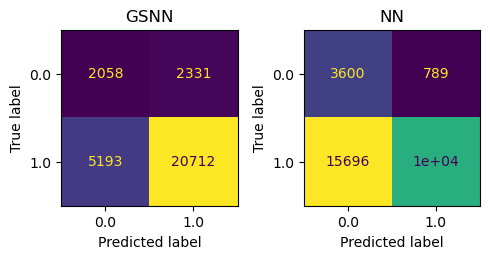

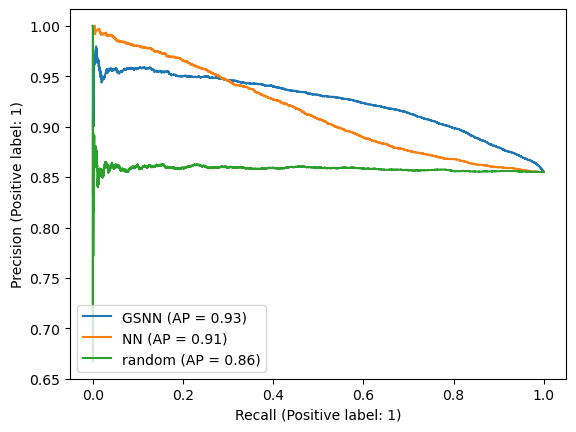

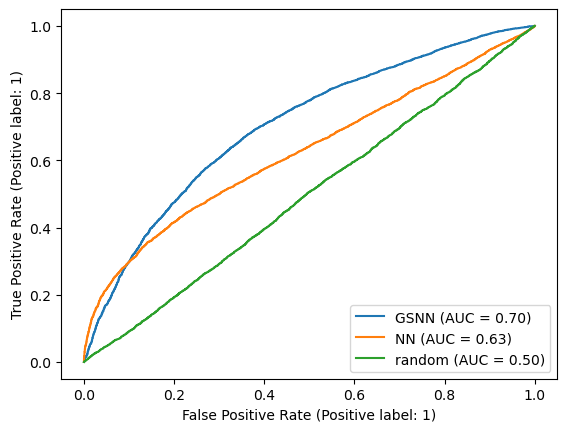

In [171]:
gsnn_pred_label = 1.*(yhat_means_gsnn > 0.5).detach().cpu().numpy().ravel()
nn_pred_label = 1.*(yhat_means_nn > 0.5).detach().cpu().numpy().ravel()
y_label = 1.*(y > 0.5).detach().cpu().numpy().ravel()
rand_pred_label = 1.*(torch.rand_like(yhat_means_gsnn) > 0.5).detach().cpu().numpy().ravel()

print('GSNN acc.:', (gsnn_pred_label == y_label).mean())
print('NN acc.:', (nn_pred_label == y_label).mean())
print('RAND acc.:', (rand_pred_label == y_label).mean())

f, axes= plt.subplots(1,2, figsize=(5,10))
axes[0].set_title('GSNN')
axes[1].set_title('NN')
ConfusionMatrixDisplay.from_predictions(y_label, gsnn_pred_label, ax=axes[0], colorbar=False)
ConfusionMatrixDisplay.from_predictions(y_label, nn_pred_label, ax=axes[1], colorbar=False)
plt.tight_layout()
plt.show()

f, ax = plt.subplots(1,1)
PrecisionRecallDisplay.from_predictions(y_label, yhat_means_gsnn.detach().cpu().numpy(), ax=ax, name='GSNN')
PrecisionRecallDisplay.from_predictions(y_label, yhat_means_nn.detach().cpu().numpy(), ax=ax, name='NN')
PrecisionRecallDisplay.from_predictions(y_label, np.random.rand(len(yhat_means_nn)), ax=ax, name='random')
plt.show()

f, ax = plt.subplots(1,1)
RocCurveDisplay.from_predictions(y_label, yhat_means_gsnn.detach().cpu().numpy(), ax=ax, name='GSNN')
RocCurveDisplay.from_predictions(y_label, yhat_means_nn.detach().cpu().numpy(), ax=ax, name='NN')
RocCurveDisplay.from_predictions(y_label, np.random.rand(len(yhat_means_nn)), ax=ax, name='random')
plt.show()

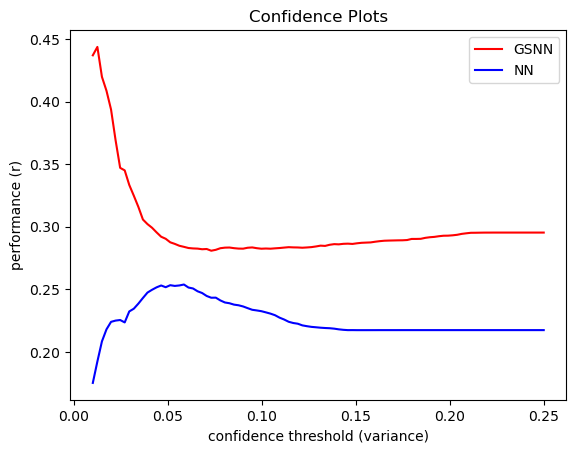

In [172]:
t = np.linspace(0.01, 0.25, 100)
rs_gsnn = [np.corrcoef(yhat_means_gsnn[yhat_vars_gsnn < tt].detach().cpu().numpy().ravel(), y[yhat_vars_gsnn < tt].detach().cpu().numpy().ravel())[0,1] for tt in t]
rs_nn = [np.corrcoef(yhat_means_nn[yhat_vars_nn < tt].detach().cpu().numpy().ravel(), y[yhat_vars_nn < tt].detach().cpu().numpy().ravel())[0,1] for tt in t]

plt.figure()
plt.plot(t, rs_gsnn, 'r-', label='GSNN')
plt.plot(t, rs_nn, 'b-', label='NN')
plt.legend()
plt.title('Confidence Plots')
plt.xlabel('confidence threshold (variance)')
plt.ylabel('performance (r)')
plt.show()

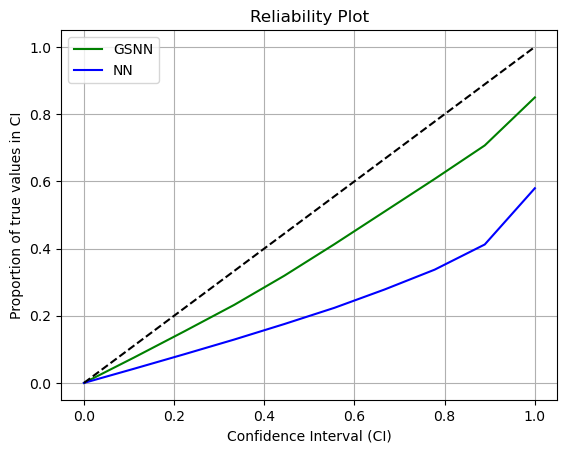

In [159]:
N=100

plt.figure()
alphas = torch.linspace(0,1,10)
plt.plot(1-alphas, [compute_picp(yhat_dist_gsnn, torch.clamp((y+1)/2, 0.05, 0.95), alpha=alpha, N=N) for alpha in alphas], 'g-', label='GSNN')
plt.plot(1-alphas, [compute_picp(yhat_dist_nn, torch.clamp((y+1)/2, 0.05, 0.95), alpha=alpha, N=N) for alpha in alphas], 'b-', label='NN')
plt.plot((0,1), (0,1), 'k--')
plt.xlabel('Confidence Interval (CI)')
plt.ylabel('Proportion of true values in CI')
plt.grid()
plt.title('Reliability Plot')
plt.legend()
plt.show()

In [88]:
xx.size()

torch.Size([1, 5374])

In [75]:
almanac3.CONCUNIT2.unique()

array(['M'], dtype=object)

In [71]:
almanac3.columns

Index(['COMBODRUGSEQ', 'SCREENER', 'STUDY', 'TESTDATE', 'PLATE', 'PANELNBR',
       'CELLNBR', 'PREFIX1', 'NSC1', 'SAMPLE1', 'CONCINDEX1', 'CONC1',
       'CONCUNIT1', 'PREFIX2', 'NSC2', 'SAMPLE2', 'CONCINDEX2', 'CONC2',
       'CONCUNIT2', 'PERCENTGROWTH', 'PERCENTGROWTHNOTZ', 'TESTVALUE',
       'CONTROLVALUE', 'TZVALUE', 'EXPECTEDGROWTH', 'SCORE', 'VALID', 'PANEL',
       'CELLNAME', 'pert_id_1', 'pert_id_2', 'cell_iname'],
      dtype='object')

In [117]:
# http://drugcombdb.denglab.org/download (Drug Comb DB) 
dcdb = pd.read_csv('../../data/drugcombs_response.csv', low_memory=False)
dcdb.head()

,BlockID,Row,Col,DrugRow,DrugCol,ConcRow,ConcCol,Response,ConcRowUnit,ConcColUnit,source
0,1,1,1,5-FU,ABT-888,0.0,0.00,100.000626,uM,uM,ONEIL
1,1,1,2,5-FU,ABT-888,0.0,0.35,101.993009,uM,uM,ONEIL
2,1,1,3,5-FU,ABT-888,0.0,1.08,100.957673,uM,uM,ONEIL
3,1,1,4,5-FU,ABT-888,0.0,3.25,99.930372,uM,uM,ONEIL
4,1,1,5,5-FU,ABT-888,0.0,10.00,98.861202,uM,uM,ONEIL


In [120]:
cheminfo = pd.read_csv('../../data/drug_chemical_info.csv', encoding = "ISO-8859-1")
cheminfo.head()

,drugName,cIds,drugNameOfficial,molecularWeight,smilesString
0,Bendamustine,CIDs00065628,bendamustine,358.26284,CN1C2=C(C=C(C=C2)N(CCCl)CCCl)N=C1CCCC(=O)O
1,Lonidamine,CIDs00039562,lonidamine,321.15810,C1=CC=C2C(=C1)C(=NN2CC3=C(C=C(C=C3)Cl)Cl)C(=O)O
2,Lenalidomide,CIDs00216326,lenalidomide,259.26062,C1CC(=O)NC(=O)C1N2CC3=C(C2=O)C=CC=C3N
3,Cladribine,CIDs00020279,cladribine,285.68698,C1C(C(OC1N2C=NC3=C2N=C(N=C3N)Cl)CO)O
4,Pentostatin,CIDs00439693,pentostatin,268.26914,C1C(C(OC1N2C=NC3=C2NC=NCC3O)CO)O


In [121]:
data = torch.load('../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/Data.pt')
model = torch.load('../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/model-100.pt')
druginfo = pd.read_csv('../../data/compoundinfo_beta.txt', sep='\t')[lambda x: x.pert_id.isin(data.drugspace)]

In [122]:
druginfo.head()

,pert_id,cmap_name,target,moa,canonical_smiles,inchi_key,compound_aliases
410,BRD-K42805893,AZD-9291,NaN,NaN,COc1cc(N(C)CCN(C)C)c(NC(=O)C=C)cc1Nc1nccc(n1)-...,DUYJMQONPNNFPI-UHFFFAOYSA-N,osimertinib
508,BRD-K62391742,GDC-0199,NaN,NaN,CC1(C)CCC(CN2CCN(CC2)c2ccc(C(=O)NS(=O)(=O)c3cc...,LQBVNQSMGBZMKD-UHFFFAOYSA-N,venetoclax
605,BRD-K43002773,GDC-0068,AKT3,Akt inhibitor,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...,GRZXWCHAXNAUHY-NSISKUIASA-N,ipatasertib
606,BRD-K43002773,GDC-0068,AKT1,Akt inhibitor,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...,GRZXWCHAXNAUHY-NSISKUIASA-N,ipatasertib
607,BRD-K43002773,GDC-0068,AKT2,Akt inhibitor,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...,GRZXWCHAXNAUHY-NSISKUIASA-N,ipatasertib


In [144]:
druginfo_a = druginfo.merge(cheminfo, left_on='canonical_smiles', right_on='smilesString')
druginfo_b = druginfo.assign(cmap_lower = lambda x: x.cmap_name.str.lower()).merge(cheminfo.assign(drug_lower = lambda x: x.drugName.str.lower()), right_on='drug_lower', left_on='cmap_lower')
druginfo_c = druginfo.assign(cmap_lower = lambda x: x.compound_aliases.str.lower()).merge(cheminfo.assign(drug_lower = lambda x: x.drugName.str.lower()), right_on='drug_lower', left_on='cmap_lower')
druginfo_c = druginfo_c[lambda x: ~(x.drug_lower.isna() & x.cmap_lower.isna())]
druginfo2 = pd.concat([druginfo_a, druginfo_b, druginfo_c], axis=0)
#druginfo2[['drugName', 'drugNameOfficial', 'pert_id', 'cmap_name', 'compound_aliases']].drop_duplicates().tail(25)
dcdb2brd = druginfo2[['drugName', 'pert_id']].drop_duplicates()
print(f'overlap in dcdb/gsnn: {dcdb2brd.shape[0]}/{len(data.drugspace)}')
dcdb2brd.head()

overlap in dcdb/gsnn: 277/503


,drugName,pert_id
0,NVP-AUY922,BRD-K65182930
2,Saracatinib,BRD-U07805514
4,MC-1568,BRD-K94335714
5,Everolimus,BRD-A25736793
6,NSC733504,BRD-A25736793


In [148]:
dcdb2 = dcdb[lambda x: x.DrugRow.isin(dcdb2brd.drugName) & x.DrugCol.isin(dcdb2brd.drugName)]
print('# comb. drugs applicable to GSNN:', dcdb2.shape[0])
dcdb2.head()

# comb. drugs applicable to GSNN: 932


,BlockID,Row,Col,DrugRow,DrugCol,ConcRow,ConcCol,Response,ConcRowUnit,ConcColUnit,source
2309700,93334,1,1,EPTIFIBATIDE,MESALAZINE,0.0,0.0,100.630626,uM,uM,CLOUD
2309701,93334,1,2,EPTIFIBATIDE,MESALAZINE,0.0,39.2,83.250836,uM,uM,CLOUD
2309702,93334,2,1,EPTIFIBATIDE,MESALAZINE,5.3,0.0,80.589816,uM,uM,CLOUD
2309703,93334,2,2,EPTIFIBATIDE,MESALAZINE,5.3,39.2,92.418405,uM,uM,CLOUD
2467472,132471,1,1,RALOXIFENE,NSC733504,0.0,0.0,100.000626,uM,uM,ALMANAC


In [152]:
dcdb2.tail()

,BlockID,Row,Col,DrugRow,DrugCol,ConcRow,ConcCol,Response,ConcRowUnit,ConcColUnit,source
5063979,294752,3,4,RALOXIFENE,NSC733504,0.1,0.0600,51.124875,uM,uM,ALMANAC
5063980,294752,4,1,RALOXIFENE,NSC733504,1.0,0.0000,93.069405,uM,uM,ALMANAC
5063981,294752,4,2,RALOXIFENE,NSC733504,1.0,0.0006,100.850262,uM,uM,ALMANAC
5063982,294752,4,3,RALOXIFENE,NSC733504,1.0,0.0060,58.087610,uM,uM,ALMANAC
5063983,294752,4,4,RALOXIFENE,NSC733504,1.0,0.0600,50.541045,uM,uM,ALMANAC


In [159]:
dcdb2.BlockID.unique()

array([ 93334, 132471, 138644, 147480, 149292, 149453, 151606, 155335,
       158605, 160444, 166686, 174738, 175092, 177980, 181365, 182616,
       184966, 188845, 198091, 198441, 199263, 200302, 212344, 212440,
       214056, 214270, 216223, 220829, 227026, 227083, 231593, 233885,
       235560, 240177, 242797, 245171, 246048, 249103, 249473, 252043,
       253885, 254813, 256051, 257780, 261523, 262645, 262780, 263009,
       263068, 267401, 269257, 271490, 278027, 284522, 284923, 285499,
       288745, 291197, 294752])

In [156]:
db_cell = pd.read_csv('../../data/cell_Line.csv')
db_cell.head()

,cellName,cosmicId,tag
0,786-0,905947.0,NaN
1,A498,905948.0,NaN
2,A549/ATCC,905949.0,NaN
3,ACHN,905950.0,NaN
4,CCRF-CEM,905952.0,NaN


In [164]:
db_cell.tag.unique()

array([nan, 'COLO-205', 'HCC2998', 'HL-60', 'HT-29', 'IGROV-1', 'LOXIMVI',
       'Malme-3M', 'NCI-ADR-RES', 'SF268', 'SF295', 'SF539', 'SNB19',
       'SNB75', 'SW620', 'T47D', 'TK10', '人乳腺癌', 'RXF393', 'U031',
       'Hs-578-T', 'MDA-MB-231', '人结肠癌', 'EFM-192A', 'ES-2', 'HCT-116',
       'HT-144', '人乳腺癌细胞', 'LNCaP-Clone-FGC', 'MDA-MB-436', 'NCI-H1650',
       'NCI-H2122', 'NCI-H23', 'NCI-H460', 'NCI-H520', 'OCUB-M', 'OV-90',
       'OVCAR-3', 'RPMI-7951', 'SK-MES-1', 'SK-MEL-30', 'SK-OV-3',
       'UACC-62', 'UWB1.289', '人卵巢癌UWB1.289+BRCA1 ', 'MSTO-211H', 'A375',
       '人黑色素瘤', '人弥漫B细胞淋巴瘤'], dtype=object)

In [163]:
db_cell.cosmicId.dropna().astype(int).unique()

array([ 905947,  905948,  905949,  905950,  905952,  905961,  905935,
        905970,  905971,  905937,  905936,  905938,  905972,  905973,
        905939,  905968,  905940,  905989,  905974,  905953,  905946,
        905958,  905987,  905942,  905941,  905967,  905943,  905990,
        905991,  905964,  905986,  905985,  905984,  905959,  905966,
        905982,  905965,  905962,  905983,  905977,  908123,  905945,
        905980,  905951,  905975,  905988,  905944,  905976,  905956,
        905969,  905934,  905978,  905955,  905979,  905981,  905963,
        905957,  905960,  905933,  905954,  906792,  906804,  906793,
        910851,  906825, 1240128,  907067,  907788,  907790, 1240172,
        687800,  722046,  908443,  909256, 1240197,  909255,  909698,
        910903,  909728,  909726,  909755, 1480374, 1299075,  908152,
        909784,  925339,  753596])

In [ ]:
set(db_cell.cosmicId.dropna().astype(int).values.tolist()).intersection(set(dcdb2.BlockID.astype(int).values.tolist()))

In [150]:
siginfo = pd.read_csv(f'../../data/siginfo_beta.txt', sep='\t', low_memory=False)
cell_x_dict = {cell:get_base_X([cell], '../output/exp1/proc/', data, siginfo) for cell in data.cellspace}

In [107]:
nci_drugnames = pd.read_csv('../../data/chemnames_Aug2013.txt', low_memory=False, sep='|', header=None).rename({0:'NSC', 1:'name', 2:'name_type'}, axis=1)
nci_drugnames = nci_drugnames.assign(name_lower = lambda x: x.name.str.lower())
nci_drugnames.head()

,NSC,name,name_type,name_lower
0,1,Tolylquinone,Chemical Name,tolylquinone
1,1,p-Toluquinone,Chemical Name,p-toluquinone
2,1,Methylquinone,Chemical Name,methylquinone
3,1,"1,4-Toluquinone",Chemical Name,"1,4-toluquinone"
4,1,2-Methylquinone,Chemical Name,2-methylquinone


In [114]:
nci_smiles = pd.read_csv('../../data/NCIOPENC_SMI.txt', sep=' ', ncols=3, header=None)
nci_smiles

TypeError: read_csv() got an unexpected keyword argument 'ncols'

In [48]:
data = torch.load('../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/Data.pt')
model = torch.load('../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/model-100.pt')
druginfo = pd.read_csv('../../data/compoundinfo_beta.txt', sep='\t')[lambda x: x.pert_id.isin(data.drugspace)]

In [49]:
druginfo.head()

,pert_id,cmap_name,target,moa,canonical_smiles,inchi_key,compound_aliases
410,BRD-K42805893,AZD-9291,NaN,NaN,COc1cc(N(C)CCN(C)C)c(NC(=O)C=C)cc1Nc1nccc(n1)-...,DUYJMQONPNNFPI-UHFFFAOYSA-N,osimertinib
508,BRD-K62391742,GDC-0199,NaN,NaN,CC1(C)CCC(CN2CCN(CC2)c2ccc(C(=O)NS(=O)(=O)c3cc...,LQBVNQSMGBZMKD-UHFFFAOYSA-N,venetoclax
605,BRD-K43002773,GDC-0068,AKT3,Akt inhibitor,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...,GRZXWCHAXNAUHY-NSISKUIASA-N,ipatasertib
606,BRD-K43002773,GDC-0068,AKT1,Akt inhibitor,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...,GRZXWCHAXNAUHY-NSISKUIASA-N,ipatasertib
607,BRD-K43002773,GDC-0068,AKT2,Akt inhibitor,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...,GRZXWCHAXNAUHY-NSISKUIASA-N,ipatasertib


In [108]:
nci2brd1 = nci_drugnames.merge(druginfo.assign(cmap_name_lower = lambda x: x.cmap_name.str.lower()), right_on='cmap_name_lower', left_on='name_lower')[['pert_id', 'NSC', 'name_lower', 'cmap_name', 'compound_aliases']]
nci2brd2 = nci_drugnames.merge(druginfo.assign(alias_lower = lambda x: x.compound_aliases.str.lower()), right_on='alias_lower', left_on='name_lower')[['pert_id', 'NSC', 'name_lower', 'cmap_name', 'compound_aliases']]
nci2brd = pd.concat([nci2brd1, nci2brd2], axis=0).drop_duplicates()
nci2brd = nci2brd[lambda x: ~(x.name_lower.isna() & x.compound_aliases.isna())] # avoid nan-nan merges
nci2brd.tail()

,pert_id,NSC,name_lower,cmap_name,compound_aliases
925,BRD-A66155091,758904,trilostane,trilostane,NaN
928,BRD-K73999723,759811,telmisartan,telmisartan,NaN
930,BRD-K89162000,759851,tandutinib,tandutinib,NaN
942,BRD-A82522119,759898,tibolone,tibolone,NaN
951,BRD-K56343971,761431,vemurafenib,vemurafenib,NaN


In [110]:
nci_viab[['NSC1', 'NSC2']].dropna().astype(int)[lambda x: x.NSC1.isin(nci2brd.NSC) & x.NSC2.isin(nci2brd.NSC)]

KeyError: "None of [Index(['NSC1', 'NSC2'], dtype='object')] are in the [columns]"

In [32]:
nci_viab[['NSC1', 'NSC2', 'CONC1', 'CONCUNIT1', 'CONC2', 'CONCUNIT2', 'PERCENTGROWTH', 'PERCENTGROWTHNOTZ',  'CELLNAME', 'CELLNBR', 'TESTVALUE','CONTROLVALUE','TZVALUE','VALID']]

,NSC1,NSC2,CONC1,CONCUNIT1,CONC2,CONCUNIT2,PERCENTGROWTH,PERCENTGROWTHNOTZ,CELLNBR,CELLNAME,TESTVALUE,CONTROLVALUE,TZVALUE,VALID
0,752,3088.0,1.000000e-07,M,0.000001,M,85.979,88.159,18,786-0,332168.000,376781.548,58592.854,Y
1,752,3088.0,1.000000e-07,M,0.000010,M,100.903,100.763,18,786-0,379656.000,376781.548,58592.854,Y
2,752,3088.0,1.000000e-07,M,0.000100,M,14.147,27.498,18,786-0,103608.000,376781.548,58592.854,Y
3,752,3088.0,1.000000e-06,M,0.000001,M,71.268,75.736,18,786-0,285360.000,376781.548,58592.854,Y
4,752,3088.0,1.000000e-06,M,0.000010,M,89.278,90.945,18,786-0,342664.000,376781.548,58592.854,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3686470,681239,NaN,1.000000e-08,M,NaN,M,-51.889,NaN,16,SF-539,0.242,1.636,0.503,Y
3686471,681239,NaN,3.170000e-08,M,NaN,M,-61.133,NaN,16,SF-539,0.196,1.636,0.503,Y
3686472,681239,NaN,1.000000e-07,M,NaN,M,-62.724,NaN,16,SF-539,0.188,1.636,0.503,Y
3686473,681239,NaN,3.160000e-07,M,NaN,M,-66.799,NaN,16,SF-539,0.167,1.636,0.503,Y


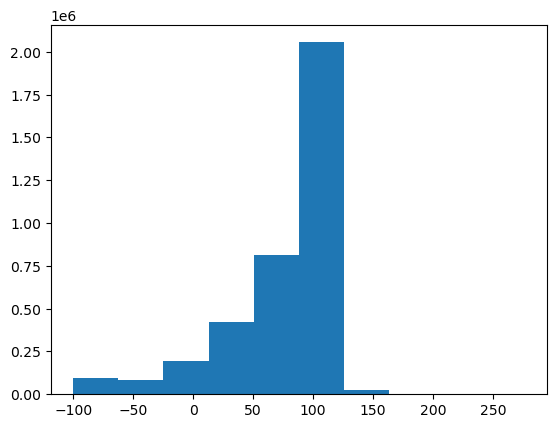

In [34]:
plt.figure()
plt.hist(nci_viab.PERCENTGROWTH.values)
plt.show()

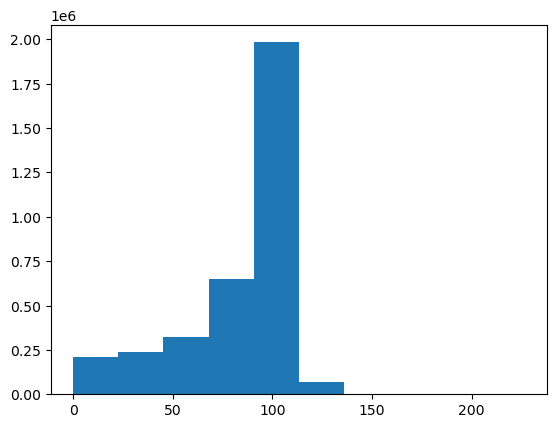

In [36]:
plt.figure()
plt.hist(nci_viab.PERCENTGROWTHNOTZ.values)
plt.show()

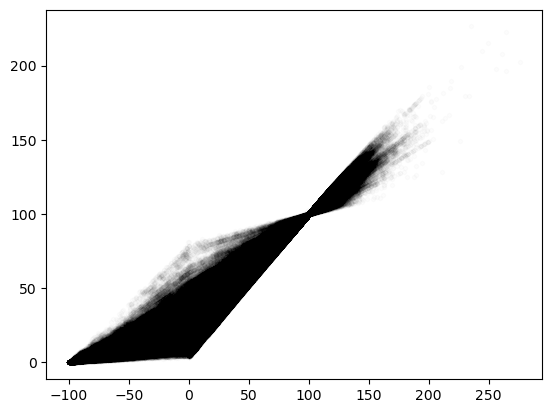

In [39]:
plt.figure()
plt.plot(nci_viab.PERCENTGROWTH.values, nci_viab.PERCENTGROWTHNOTZ.values, 'k.', alpha=0.01)
plt.show()

In [29]:
nci_viab.columns

Index(['COMBODRUGSEQ', 'SCREENER', 'STUDY', 'TESTDATE', 'PLATE', 'PANELNBR',
       'CELLNBR', 'PREFIX1', 'NSC1', 'SAMPLE1', 'CONCINDEX1', 'CONC1',
       'CONCUNIT1', 'PREFIX2', 'NSC2', 'SAMPLE2', 'CONCINDEX2', 'CONC2',
       'CONCUNIT2', 'PERCENTGROWTH', 'PERCENTGROWTHNOTZ', 'TESTVALUE',
       'CONTROLVALUE', 'TZVALUE', 'EXPECTEDGROWTH', 'SCORE', 'VALID', 'PANEL',
       'CELLNAME'],
      dtype='object')

In [28]:
np.sort(nci_viab.CELLNAME.unique())

array(['786-0', 'A498', 'A549/ATCC', 'ACHN', 'BT-549', 'CAKI-1',
       'CCRF-CEM', 'COLO 205', 'DU-145', 'EKVX', 'HCC-2998', 'HCT-116',
       'HCT-15', 'HL-60(TB)', 'HOP-62', 'HOP-92', 'HS 578T', 'HT29',
       'IGROV1', 'K-562', 'KM12', 'LOX IMVI', 'M14', 'MALME-3M', 'MCF7',
       'MDA-MB-231/ATCC', 'MDA-MB-435', 'MDA-MB-468', 'MOLT-4',
       'NCI-H226', 'NCI-H23', 'NCI-H322M', 'NCI-H460', 'NCI-H522',
       'NCI/ADR-RES', 'OVCAR-3', 'OVCAR-4', 'OVCAR-5', 'OVCAR-8', 'PC-3',
       'RPMI-8226', 'RXF 393', 'SF-268', 'SF-295', 'SF-539', 'SF-539\x1a',
       'SK-MEL-2', 'SK-MEL-28', 'SK-MEL-5', 'SK-OV-3', 'SN12C', 'SNB-19',
       'SNB-75', 'SR', 'SW-620', 'T-47D', 'TK-10', 'U251', 'UACC-257',
       'UACC-62', 'UO-31'], dtype=object)